# Deconvolve filter

### Dec 14, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events debugging

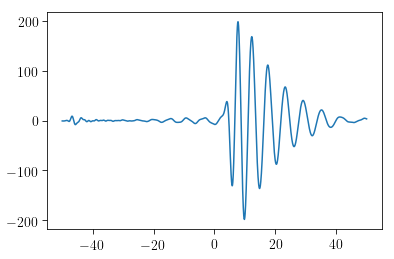

In [3]:
phi = np.deg2rad(90)
theta = np.deg2rad(90)
from scipy import signal
pol_ev = np.array([0.,0,1])
dirProp = np.array([0,1,0])
# dirProp = 
pol_ev
phi = np.arctan2(dirProp[1],dirProp[0])
theta = np.arccos(dirProp[2])
wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV
plt.plot(timeV,voltageV)

In [12]:
def weird_division(n, d):
    return n / d if (np.abs(d)>0) else 0 

def deConvolve(time, voltage, theta, phi, pol_ant):
    """
    Apply inverse of ARA antenna response
    ----------
    time : array_like
        1D array of times (ns)
    voltage : array_like
        1D array of amplitudes (mV).

    theta, phi, pol_ant: floats
    theta_antenna (radians), phi_antenna (radians), pol_antenna [0:vpol, 1:hpol]
    Returns
    -------
    time : array_like
        1D array of times (ns)
    deDis_wf : array_like
        1D array of amplitudes (mV) of de-convolved waveform.
    """
    import scipy.signal as signal
    polarization=np.array([-np.sin(phi),np.cos(phi),-1/np.sin(theta)])
    if(pol_ant == 0):
        ant = ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
        # ant.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))#Adding to convert from global coordinates to local antenna coords.
    elif(pol_ant == 1):
        ant = ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
        # ant.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))

    sampRate = len(time)/(max(time)-min(time))
    b,a = signal.bessel(4, [0.15,0.4], 'bandpass', analog=False, fs=sampRate)
    fft_v, fft_f, dT = util.doFFT(time,voltage)
    response_filter = np.array(ant.interpolate_filter(fft_f*1E6))
    dir_res = ant.antenna.directional_response(theta=theta, phi=phi, polarization=polarization)(fft_f*1E6)
    heff = ant.antenna.frequency_response(fft_f*1E6)
    response_antenna = dir_res*heff
    response = response_filter
    deDis_wf=[]
    for k in range(len(response)):
        deDis_wf.append(weird_division(fft_v[k],response[k]))
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(deDis_wf,response)
    deDis_wf = np.nan_to_num(deDis_wf)

    revert = util.doInvFFT(deDis_wf)
#     deDis_wf = revert
    deDis_wf = signal.lfilter(b, a, revert)
#     plt.plot(fft_f,abs(util.doFFT(time, deDis_wf)[0]))
#     plt.xlim(0,1000)
#     plt.yscale('log')
    return time, deDis_wf

In [13]:
deConvolve(timeV, voltageV, theta, phi,0);

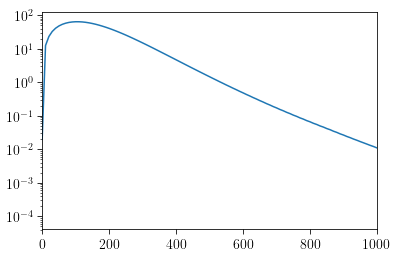

In [14]:
v,f,dT = util.doFFT(wform["time"],wform.voltage)
plt.plot(f,abs(v))
plt.xlim(0,1000)
plt.yscale('log')

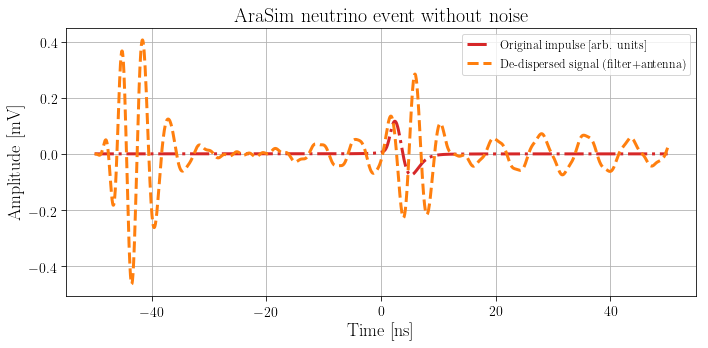

In [15]:
plt.figure(figsize=(10,5))
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV]")
# b,a = signal.bessel(4, [0.15,0.4], 'bandpass', analog=False, fs = len(wform["time"])/(max(wform["time"])-min(wform["time"])))
# filtered_noise = signal.lfilter(b, a, wform.voltage*5E2)

deD_t, deD_v = deConvolve(timeV, voltageV, theta, phi,0)
time = output.times*1E9 #in ns
voltage = output.values*1E3 #in mV
deD_t, deD_v_Antenna = util.deConvolve_antenna(deD_t, deD_v, theta, phi,0)
# deD_t, deD_v = deDisperse(time,voltage, theta, phi)
plt.plot(wform["time"],wform.voltage/1E1, "-.",lw=3,color="C3", label="Original impulse [arb. units]")
# plt.plot(deD_t,deD_v,lw=3,color="C0",label ="De-dispersed signal (filter)")
plt.plot(deD_t, deD_v_Antenna,"--",lw=3,color="C1", label = "De-dispersed signal (filter+antenna)")


# plt.plot(output.times*1E9,filtered_noise, "-.",lw=3,color="C2", label="Bandpassed (Bessel, 200-500 MHz) impulse signal [arb.]")

# plt.xlim(-10,40)
# plt.ylim(-250,250)

plt.legend()
plt.grid(True)
plt.title("AraSim neutrino event without noise")
plt.tight_layout()

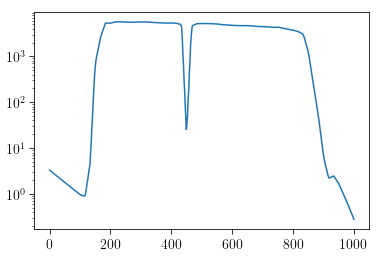

In [251]:
freq = np.linspace(0,1000,1001)
ant = ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
response_filter = np.array(ant.interpolate_filter(freq*1E6))
plt.plot(freq,abs(response_filter))
plt.yscale('log')
# plt.xlim(430,470)